# Evaluation of Polymer-augmented Model

This notebook evaluates the performance of a Random Forest model trained with
polymer-aware features and compares it against the RDKit-only baseline using the
same train–test split and model configuration. The goal is to assess whether
domain-informed feature engineering improves Tg prediction performance and
interpretability.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
meta_cols = ["SMILES", "Tg", "PID", "Polymer Class"]

df = pd.read_csv("../data/intermediate/tg_with_rdkit_descriptors.csv")
y = df["Tg"]

train_indices = pd.read_csv("../data/processed/train_idx.csv").squeeze()
test_indices = pd.read_csv("../data/processed/test_idx.csv").squeeze()

# split data into train and test sets
y_test = y.loc[test_indices]
x_rdkit_test = pd.read_csv("../data/processed/tg_rdkit/x_test_proc.csv")
x_polymer_augmented_test = pd.read_csv("../data/processed/tg_rdkit_polymer/x_test_proc.csv")

In [ ]:
rf_base = joblib.load("../models/baseline_random_forest_model.pkl")
rf_poly = joblib.load("../models/baseline_random_forest_model_polymer.pkl")

In [ ]:
y_pred_base = rf_base.predict(x_rdkit_test)
y_pred_poly = rf_poly.predict(x_polymer_augmented_test)

In [ ]:
results = pd.DataFrame({
    "Model": ["RDKit Baseline", "Polymer-aware"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_base)),
        np.sqrt(mean_squared_error(y_test, y_pred_poly))
    ],
    "R2": [
        r2_score(y_test, y_pred_base),
        r2_score(y_test, y_pred_poly)
    ]
})

results

,Model,RMSE,R2
0,RDKit Baseline,39.918709,0.875081
1,Polymer-aware,40.404883,0.872020


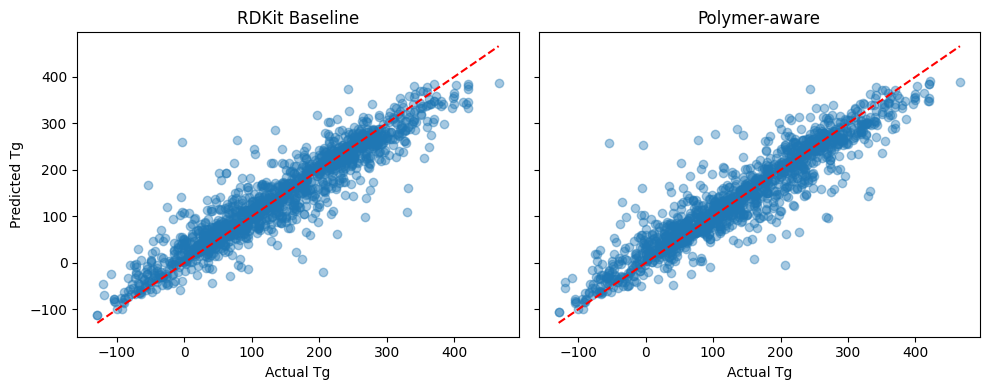

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# RDKit baseline
axes[0].scatter(y_test, y_pred_base, alpha=0.4)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
axes[0].set_title("RDKit Baseline")
axes[0].set_xlabel("Actual Tg")
axes[0].set_ylabel("Predicted Tg")

# Polymer-aware
axes[1].scatter(y_test, y_pred_poly, alpha=0.4)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
axes[1].set_title("Polymer-aware")
axes[1].set_xlabel("Actual Tg")

plt.tight_layout()
plt.show()


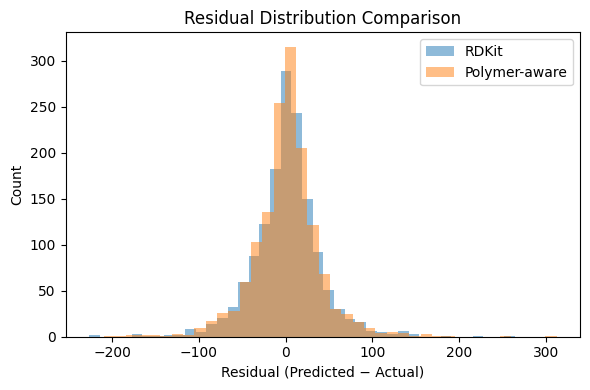

In [ ]:
res_base = y_pred_base - y_test
res_poly = y_pred_poly - y_test

plt.figure(figsize=(6, 4))
plt.hist(res_base, bins=40, alpha=0.5, label="RDKit")
plt.hist(res_poly, bins=40, alpha=0.5, label="Polymer-aware")
plt.xlabel("Residual (Predicted − Actual)")
plt.ylabel("Count")
plt.legend()
plt.title("Residual Distribution Comparison")
plt.tight_layout()
plt.show()


### Polymer-aware Model Evaluation

The polymer-aware Random Forest model achieves comparable performance to the
RDKit-only baseline, with an RMSE of approximately 40 K and an R² of 0.87 on the
held-out test set. No systematic bias is observed in the predicted versus actual
Tg plots, and the residual distributions of the two models are highly similar
and centered near zero.

While the incorporation of polymer-aware features does not lead to a significant
improvement in predictive accuracy, it enhances model interpretability. In
particular, chain flexibility descriptors such as the fraction of rotatable bonds
emerge as dominant features, consistent with established polymer physics
expectations.

These results suggest that generic RDKit descriptors already encode much of the
structural information relevant to Tg prediction in this dataset, while
polymer-aware features provide a more physically transparent representation
without degrading model performance.
